In [300]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import statsmodels.api as sm
from sklearn.metrics import r2_score
import lightgbm as lgb
from numpy import array
from scipy.stats import pearsonr
import graphviz
import GetOldTweets3 as got
from datetime import datetime, timedelta
#Directory
os.chdir("/Users/leomccarthy/Documents/Uni_GDS/Diss/Highways/Highways Data")

In [2140]:
spd = pd.read_csv("sensor_time_series.csv", index_col = "Report Date",parse_dates = True)
sensorLoc = pd.read_csv("SensorGeo.csv")
sensor = pd.read_csv('sensor.csv')
sensorLoc.set_index("Site Name", inplace = True)
mcr_w = pd.read_csv("mcr_weather.csv")

In [2141]:
cols = spd.columns.values
cols[:11] = cols[:11]+" up"
cols[11] = cols[11]+" target"
cols[12:] = cols[12:]+" down"
spd.columns = cols

In [2145]:
sensorLoc.index = cols

In [503]:
#Get Tweets Data

def ceil_dt(dt, delta):
    return (dt + (datetime.min - dt) % delta) - timedelta(minutes = 1)

dates = []
for i in ["J8","J9","J10","J12","J13","J14"]:
    
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch(i)\
                                           .setUsername("Traffic_M60")\
                                           .setSince("2019-05-01")\
                                           .setUntil("2019-10-30")\
                                           
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    for p in range(len(tweet)):
         dates.append(ceil_dt(tweet[p].date.replace(tzinfo=None), delta = timedelta(minutes = 15)))
            
date_counts = [dates.count(x) for x in set(dates)]
tweet_count = pd.DataFrame(date_counts,set(dates), columns = ["Tweet count"]).sort_index()


In [737]:
spd_t = spd.iloc[:,:20].merge(tweet_count,how = "left",left_index = True, right_index = True).fillna(0)

In [745]:
spd_all["dayofweek"] = spd.index.dayofweek

In [611]:
mcr_w["Date"] = mcr_w["Date"].astype("datetime64")
mcr_w["datetime"] = mcr_w[["Date","Hour"]].apply(lambda x: x[0] + timedelta(hours = x[1]), axis = 1)
mcr_w["datetime"] = mcr_w["datetime"] - timedelta(minutes = 1)
mcr_w.set_index("datetime",inplace = True)
mcr_w.drop(["Date","Hour"], axis = 1, inplace = True)
mcr_w.sort_index(ascending = True, inplace = True)
spd = pd.merge_asof(spd,mcr_w,left_index = True, right_index = True).fillna(0)

# ARIMA

In [2336]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(endog = spd.iloc[:,1].values,exog =spd.iloc[:,2:4] , order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

No frequency information was provided, so inferred frequency 15T will be used.
No frequency information was provided, so inferred frequency 15T will be used.


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                17663
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -48822.818
Method:                       css-mle   S.D. of innovations              3.839
Date:                Fri, 11 Sep 2020   AIC                          97659.636
Time:                        22:01:11   BIC                          97714.091
Sample:                    05-01-2019   HQIC                         97677.560
                         - 10-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.4790      0.126    -11.767      0.000      -1.725      -1.233
M60/9187A up     0.1882      0.011     16.720      0.000       0.166       0.210
M60/9192A up    -0.1566      0.010    -15.89

nan

## Converting time series data to supervised learning input

In [2401]:
from pandas import DataFrame
from pandas import concat

def normalize(data):
    mean = data.mean()
    std = data.std()
    
    data = (data - mean )/ std
    return data


def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(df.columns[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(df.columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    X = normalize(agg.iloc[:,:df.values.shape[1]*n_in ])
    y = agg.iloc[:,df.values.shape[1]*n_in + (train.values.shape[1] * (n_out - 1)) ]
    
    return X,y

 
 

In [2075]:

def get_closest(osm_way,n=50):
    dm = []
    for i in sensorLoc.index:
        c1 = np.array([sensorLoc.loc[i]["Long"],sensorLoc.loc[i]["Lat"]])
        c2 = np.array([sensorLoc.loc[osm_way]["Long"],sensorLoc.loc[osm_way]["Lat"]])
        
        dist = np.linalg.norm(c1-c2)
        dm.append(dist)
        
    
    return pd.DataFrame(dm,sensorLoc.index, columns = ["Dist"]).sort_values(by = "Dist")[:n]

In [2146]:
dist_cor = get_closest('M60/9223A target')

In [10]:
def get_correlated(df,osm_way,n=50):
    cor = []
    for i in ways:
        cor.append(pearsonr(df.loc[:,osm_way].iloc[1:].values,df.loc[:,i].shift()[1:])[0])
        
        
    
    return pd.DataFrame(cor,ways, columns = ["Cor"]).sort_values(by = "Cor", ascending = False)[:n]
        

# Autocorrelations

In [2326]:
def get_cor(p,df):
    cor = []
    for i in range(-1000,1001):
        if i < 0:
            c = pearsonr(df.iloc[:i,0].values,df[p].shift(i)[:i].values )[0]
        else:
            c = pearsonr(df.iloc[i:,0].values,df[p].shift(i)[i:].values )[0]
        cor.append(c)
    
    return cor

def get_peak_cor(p,df):
    cor = []
    for i in range(-1000,1001):
        if i < 0:
            c = pearsonr(df.iloc[:,0].loc[spd.index.hour.isin(peak)][:i].values,df.loc[:,p].shift(i).loc[spd.index.hour.isin(peak)][:i].values )[0]
        else:
            c = pearsonr(df.iloc[:,0].loc[spd.index.hour.isin(peak)][i:].values,df.loc[:,p].shift(i).loc[spd.index.hour.isin(peak)][i:].values )[0]
        cor.append(c.round(5))
    
    return cor
    

In [2193]:
pearsonr(spd_all.iloc[1:,0].values,spd_all.loc[:,"M60/9171A up"].shift(1)[1:].values )[0]

0.47511446760683573

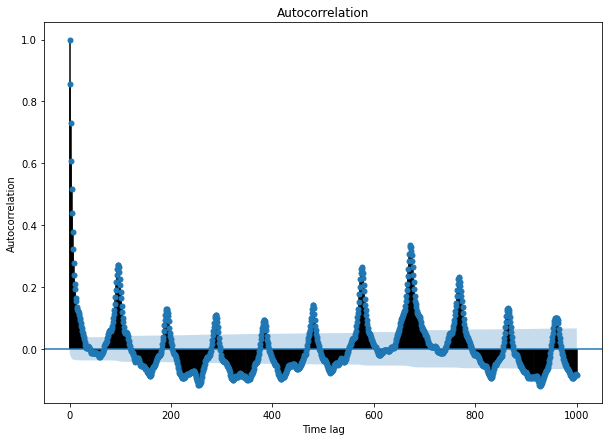

In [2322]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize = (10,7))
plot_acf(spd_down.iloc[:,0],ax,lags = 1000)
plt.xlabel("Time lag")
plt.ylabel("Autocorrelation")
plt.savefig("auto.png", dpi = 400)

In [2229]:
dists = get_closest('M60/9223A target')


In [2233]:
dist_cors = []

for i in dist_cor.index:
    dist_cors.append(get_cor(i,spd_all))
dist_cors = pd.DataFrame(dist_cors)

In [2234]:
dist_cors["dist"] = dists["Dist"].values

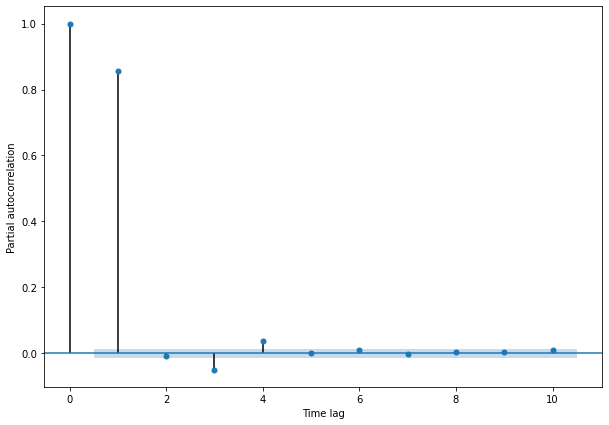

In [2281]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize = (10,7))
plot_pacf(spd_down.iloc[:,0],ax, lags = 10, title = "")
plt.savefig("partial_auto.png", dpi = 400)
plt.xlabel("Time lag")
plt.ylabel('Partial autocorrelation')
plt.savefig("pauto.png", dpi = 400)

In [2328]:
up_cors = []

for i in spd_up.columns[0:]:
    up_cors.append(get_cor(i,spd_up))

down_cors = []
for i in spd_down.columns[0:]:
    down_cors.append(get_cor(i,spd_down))
    
    

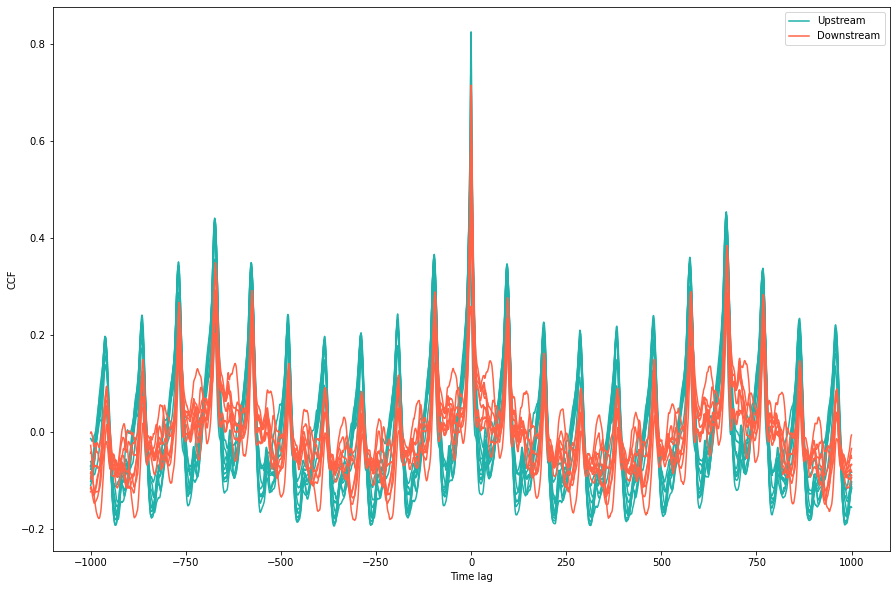

In [2330]:
plt.figure(figsize = (15,10))
for i in range(1,11):
    plt.plot(range(-1000,1001),up_cors[i],color = "lightseagreen")
for i in range(1,9):
    plt.plot(range(-1000,1001),down_cors[i], color ='tomato')
    leg = plt.legend(labels = ["Upstream","Downstream"])
    leg.legendHandles[0].set_color("lightseagreen")
    leg.legendHandles[1].set_color('tomato')
    
    plt.xlabel("Time lag")
    plt.ylabel("CCF")
plt.savefig("ccf_long.png",dpi = 400)
   

In [2331]:
peak = [17,18,19]

up_cors_peak = []
down_cors_peak = []
for i in spd_up.columns[1:]:
    up_cors_peak.append(get_peak_cor(i,spd_up))
    
for i in spd_down.columns[1:]:
    down_cors_peak.append(get_peak_cor(i,spd_down))


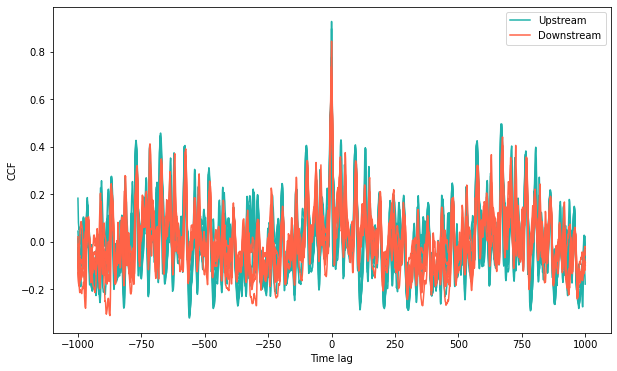

In [2334]:


plt.figure(figsize = (10,6))
for i in range(1,11):
    plt.plot(range(-1000,1001),up_cors_peak[i],color = "lightseagreen")
for i in range(1,9):
    plt.plot(range(-1000,1001),down_cors_peak[i], color ='tomato')
    leg = plt.legend(labels = ["Upstream","Downstream"])
    leg.legendHandles[0].set_color('lightseagreen')
    leg.legendHandles[1].set_color('tomato')
    plt.xlabel("Time lag")
    plt.ylabel("CCF")
plt.savefig("peakccf_long.png",dpi = 400)

In [1640]:
from scipy.stats import pearsonr
pearsonr(spd.iloc[3:,1].values,spd.iloc[:,10].shift(3)[3:].values)

(0.44719541827255493, 0.0)

In [145]:
from scipy.stats import pearsonr
cor = []
p = []
for i in X_train.columns:
    cor.append(pearsonr(X_train.loc[:,i].values,y_train)[0])
    p.append(pearsonr(X_train.loc[:,i].values,y_train)[1])

In [184]:
cors = pd.DataFrame(np.abs(cor),X_train.columns, columns = ["Cor"]).assign(p_val = p).sort_values(by = "Cor", ascending = False)

In [1372]:
target_i = 11
target = spd.columns[target_i]

In [2304]:
spd_all = spd[[target]+[c for c in spd if c not in [target]]]
spd_up = spd_all.iloc[:,:target_i+1]
spd_down = spd.iloc[:,11:21]

In [1374]:
spd_all_ex = spd_all.merge(tweet_count,how = "left",left_index = True, right_index = True).fillna(0)
spd_all_ex["dayofweek"] = spd.index.dayofweek

In [990]:
abs(sensor.loc[sensor["Site Name"] == target,"Avg mph"] - sensor.loc[sensor["Site Name"] == target,"Sensor Overall Mean"]).mean()

2.585721592551302

In [2352]:
train = spd_all.loc[:"2019-09-30",]
test =spd_all.loc['2019-10-01':,]

train_up = spd_up.loc[:"2019-09-30",]
test_up =spd_up.loc['2019-10-01':,]

train_down = spd_down.loc[:"2019-09-30",]
test_down =spd_down.loc['2019-10-01':,]


train_ex = spd_all_ex.loc[:"2019-09-30",]
test_ex =spd_all_ex.loc['2019-10-01':,]

train_uni = spd_all.loc[:"2019-09-30",].iloc[:,:1]
test_uni = spd_all.loc['2019-10-01':,].iloc[:,:1]

look_back = 6

X_train_uni,y_train = series_to_supervised(train_uni,look_back,1)
X_val_uni,y_val = series_to_supervised(test_uni,look_back,1)


X_train,y_train = series_to_supervised(train_uni,look_back,1)
X_val,y_val = series_to_supervised(test_uni,look_back,1)

# X_train_up,y_train = series_to_supervised(train_up,look_back,1)
# X_val_up,y_val = series_to_supervised(test_up,look_back,1)

# X_train_down,y_train = series_to_supervised(train_down,look_back,1)
# X_val_down,y_val = series_to_supervised(test_down,look_back,1)

X_train_ex,y_train = series_to_supervised(train_ex,look_back,1)
X_val_ex,y_val = series_to_supervised(test_ex,look_back,1)



In [1131]:
abs(spd_all.iloc[2:,:1] - spd_all.iloc[:,:1].shift(2)[2:]).mean()

M60/9223A    2.154871
dtype: float64

# OLS

In [2409]:
X_train,y_train = series_to_supervised(train,look_back,1)
X_val,y_val = series_to_supervised(test,look_back,1)



In [2410]:
X_train_lm = sm.add_constant(X_train)
X_val_lm = sm.add_constant(X_val)

In [2411]:
model = sm.OLS(y_train,X_train_lm)
model = model.fit()
print("MAE = ",abs((y_val.values - (model.predict(X_val_lm).values))).mean(),
     "RMSE = " ,(((y_val.values - (model.predict(X_val_lm).values))**2).mean())**0.5  )
model.summary()

MAE =  1.6965921319357815 RMSE =  3.0825738103346607


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     M60/9223A target(t)   R-squared:                       0.787
Model:                             OLS   Adj. R-squared:                  0.785
Method:                  Least Squares   F-statistic:                     425.8
Date:                 Fri, 11 Sep 2020   Prob (F-statistic):               0.00
Time:                         22:27:49   Log-Likelihood:                -36258.
No. Observations:                14682   AIC:                         7.277e+04
Df Residuals:                    14555   BIC:                         7.374e+04
Df Model:                          126                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    55.5402      0.024   2343.281      0.000      55.494      55.587
M60/9223A target(t-6)     0.0841      0.070      1.202      0.229      -0.053       0.221
M60/9171A up(t-6)        -0.1415      0.128     -1.106      0.269      -0.392       0.109
M60/9179A up(t-6)         0.1707      0.180      0.949      0.343      -0.182       0.523
M60/9187A up(t-6)        -0.1072      0.194     -0.553      0.580      -0.487       0.273
M60/9192A up(t-6)        -0.6983      0.221     -3.165      0.002      -1.131      -0.266
M60/9195A up(t-6)         1.0034      0.195      5.152      0.000       0.622       1.385
M60/9196K up(t-6)        -0.2877      0.125     -2.303      0.021      -0.533      -0.043
M60/9205A up(t-6)         0.7032      0.201      3.499      0.000       0.309       1.097
M60/9206A up(t-6)         0.4046      0.122      3.309      0.001       0.165       0.644
M60/9209A up(t-6)        -1.4061      0.157     -8.967      0.000      -1.713      -1.099
M60/9210J up(t-6)        -0.0726      0.048     -1.523      0.128      -0.166       0.021
M60/9213A up(t-6)         0.6653      0.096      6.942      0.000       0.477       0.853
M60/9229L down(t-6)      -0.1257      0.036     -3.464      0.001      -0.197      -0.055
M60/9242A down(t-6)      -0.1535      0.057     -2.692      0.007      -0.265      -0.042
M60/9262A down(t-6)      -0.0344      0.070     -0.491      0.624      -0.172       0.103
M60/9277A down(t-6)      -0.0636      0.087     -0.729      0.466      -0.235       0.107
M60/9288A down(t-6)      -0.0272      0.089     -0.304      0.761      -0.202       0.148
M60/9292A down(t-6)      -0.1512      0.077     -1.968      0.049      -0.302      -0.001
M60/9298K down(t-6)       0.0741      0.051      1.461      0.144      -0.025       0.174
M60/9304A down(t-6)      -0.0935      0.106     -0.886      0.376      -0.300       0.113
M60/9309A down(t-6)       0.1660      0.096      1.728      0.084      -0.022       0.354
M60/9223A target(t-5)    -0.0250      0.077     -0.325      0.745      -0.176       0.126
M60/9171A up(t-5)        -0.0791      0.147     -0.538      0.591      -0.367       0.209
M60/9179A up(t-5)         0.1029      0.194      0.530      0.596      -0.278       0.484
M60/9187A up(t-5)        -0.0105      0.216     -0.049      0.961      -0.433       0.412
M60/9192A up(t-5)         0.5379      0.248      2.171      0.030       0.052       1.024
M60/9195A up(t-5)        -0.8042      0.217     -3.705      0.000      -1.230      -0.379
M60/9196K up(t-5)        -0.0282      0.138     -0.204      0.838      -0.300       0.243
M60/9205A up(t-5)         0.4463      0.215      2.079      0.038       0.026       0.867
M60/9206A up(t-5)        -0.8550      0.125     -6.856      0.000      -1.099      -0.611
M60/9209A up

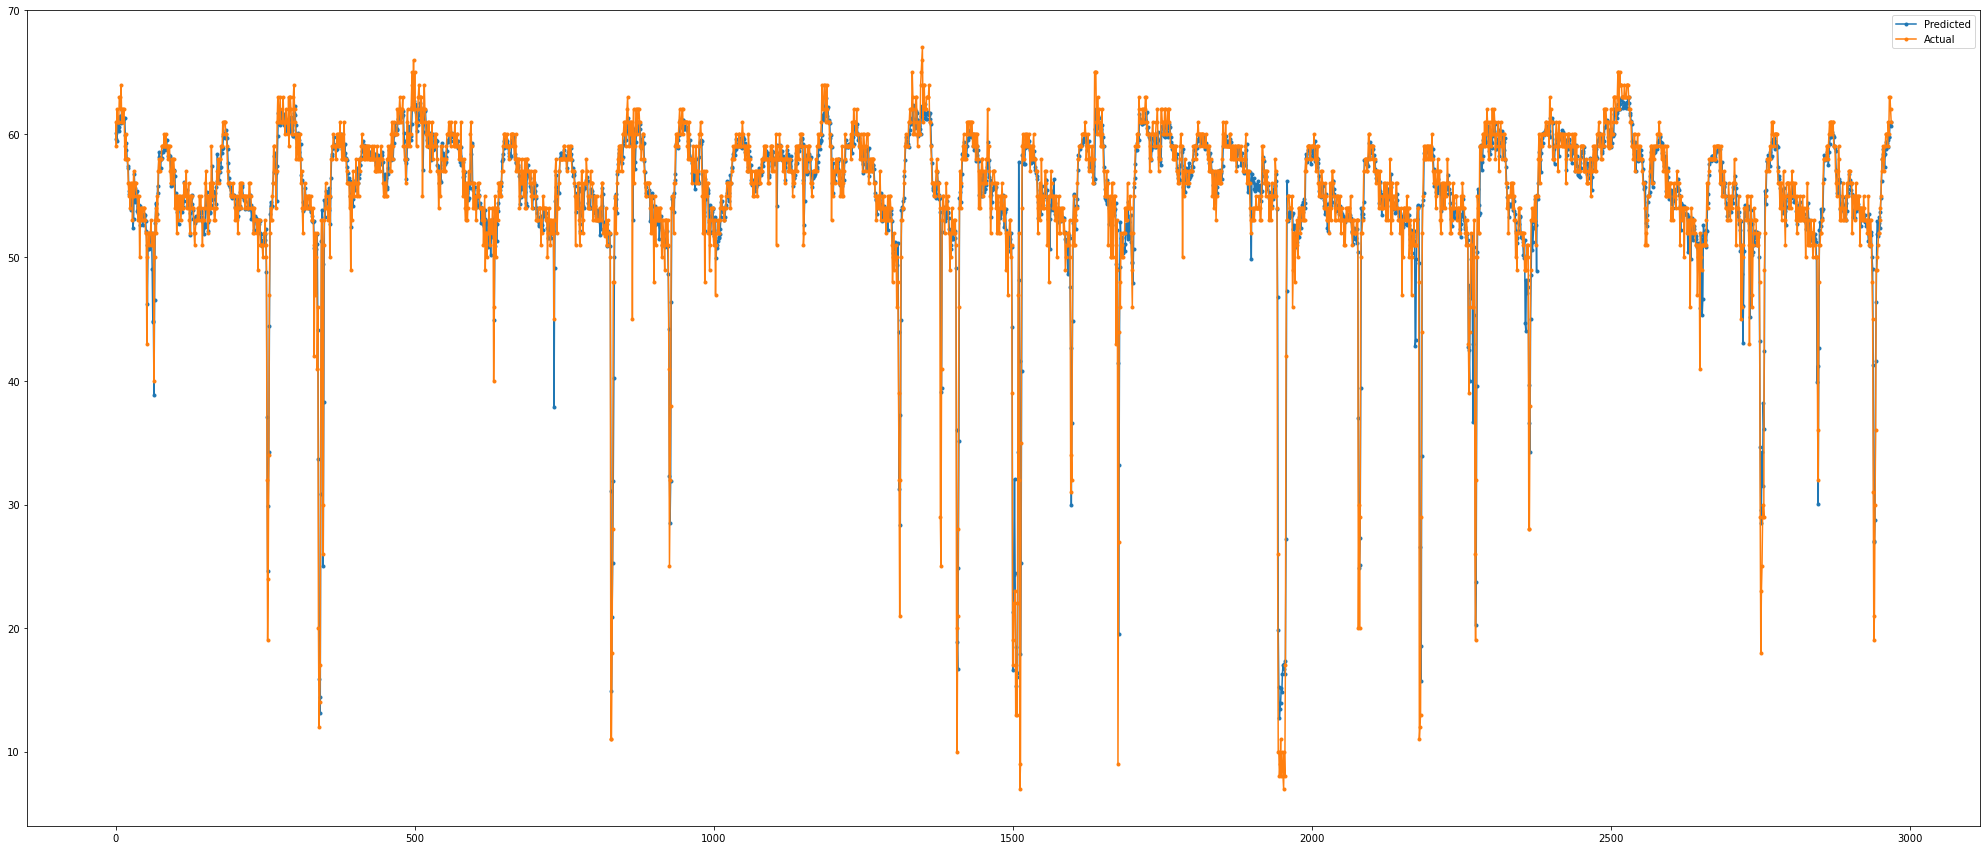

In [1190]:
plt.figure(figsize = (35,15))
plt.plot(model.predict(X_val), marker = ".")
plt.plot(y_val.values, marker = ".")
plt.legend(labels = ["Predicted","Actual"])

# LGBM 

In [2398]:
X_train_uni,y_train = series_to_supervised(train_uni,look_back,1)
X_val_uni,y_val = series_to_supervised(test_uni,look_back,1)



In [2399]:
train_data_uni = lgb.Dataset(X_train_uni, label=y_train)
test_data_uni = lgb.Dataset(X_val_uni, label=y_val)

train_data = lgb.Dataset(X_train_ex, label=y_train)
test_data = lgb.Dataset(X_val_ex, label=y_val)

train_data_up = lgb.Dataset(X_train_up, label=y_train)
test_data_up = lgb.Dataset(X_val_up, label=y_val)

train_data_down = lgb.Dataset(X_train_down, label=y_train)
test_data_down = lgb.Dataset(X_val_down, label=y_val)

train_data_ex = lgb.Dataset(X_train_ex, label=y_train)
test_data_ex = lgb.Dataset(X_val_ex, label=y_val)

In [1182]:
from time import time

In [2400]:
parameters = {
    
    'objective': 'regression',
    'metric': 'mae',
    'feature_fraction':0.9,
    'bagging_fraction':0.5,
    'boosting': 'gbdt',
    'num_leaves': 64,
    'bagging_freq': 4,
    'learning_rate': 0.007,
    'verbose': 0
}

# t0=time()
# model_uni = lgb.train(parameters,
#                         train_data_uni,
#                         valid_sets=test_data_uni,
#                         num_boost_round=50000,
#                         early_stopping_rounds=100)

# print( "training time:", round(time()-t0, 3), "s")

model_all = lgb.train(parameters,
                        train_data_uni,
                        valid_sets=test_data_uni,
                        num_boost_round=50000,
                       early_stopping_rounds=100)

# model_up = lgb.train(parameters,
#                         train_data_up,
#                         valid_sets=test_data_up,
#                         num_boost_round=50000,
#                        early_stopping_rounds=100)

# model_down = lgb.train(parameters,
#                         train_data_down,
#                         valid_sets=test_data_down,
#                         num_boost_round=50000,
#                        early_stopping_rounds=100)
# model_ex = lgb.train(parameters,
#                         train_data_ex,
#                         valid_sets=test_data_ex,
#                         num_boost_round=50000,
#                         early_stopping_rounds=100)



[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l1: 3.86
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 3.83748
[3]	valid_0's l1: 3.81505
[4]	valid_0's l1: 3.79286
[5]	valid_0's l1: 3.77092
[6]	valid_0's l1: 3.74915
[7]	valid_0's l1: 3.72786
[8]	valid_0's l1: 3.70642
[9]	valid_0's l1: 3.68496
[10]	valid_0's l1: 3.6653
[11]	valid_0's l1: 3.64563
[12]	valid_0's l1: 3.62454
[13]	valid_0's l1: 3.60323
[14]	valid_0's l1: 3.58217
[15]	valid_0's l1: 3.56126
[16]	valid_0's l1: 3.5406
[17]	valid_0's l1: 3.52061
[18]	valid_0's l1: 3.50099
[19]	valid_0's l1: 3.48123
[20]	valid_0's l1: 3.4615
[21]	valid_0's l1: 3.44175
[22]	valid_0's l1: 3.42211
[23]	valid_0's l1: 3.40278
[24]	va

[308]	valid_0's l1: 1.71965
[309]	valid_0's l1: 1.71921
[310]	valid_0's l1: 1.71848
[311]	valid_0's l1: 1.71749
[312]	valid_0's l1: 1.71646
[313]	valid_0's l1: 1.71587
[314]	valid_0's l1: 1.71529
[315]	valid_0's l1: 1.71454
[316]	valid_0's l1: 1.71373
[317]	valid_0's l1: 1.71289
[318]	valid_0's l1: 1.71224
[319]	valid_0's l1: 1.71145
[320]	valid_0's l1: 1.7108
[321]	valid_0's l1: 1.71015
[322]	valid_0's l1: 1.70956
[323]	valid_0's l1: 1.70934
[324]	valid_0's l1: 1.70913
[325]	valid_0's l1: 1.70853
[326]	valid_0's l1: 1.70796
[327]	valid_0's l1: 1.70759
[328]	valid_0's l1: 1.70704
[329]	valid_0's l1: 1.70667
[330]	valid_0's l1: 1.70637
[331]	valid_0's l1: 1.70599
[332]	valid_0's l1: 1.70557
[333]	valid_0's l1: 1.70504
[334]	valid_0's l1: 1.70457
[335]	valid_0's l1: 1.70407
[336]	valid_0's l1: 1.70341
[337]	valid_0's l1: 1.70281
[338]	valid_0's l1: 1.70224
[339]	valid_0's l1: 1.70176
[340]	valid_0's l1: 1.7013
[341]	valid_0's l1: 1.70093
[342]	valid_0's l1: 1.70057
[343]	valid_0's l1: 1.

In [42]:

tree = lgb.create_tree_digraph(model, orientation = "vertical",tree_index = 0, engine = 'dot', filename = "lgb_tree.gv", format = "png")
#tree.render('dot', 'png', 'lgb_tree.gv')\


'png/dot.png'

In [1562]:
lb = []
err = []
for i in range(1,11):
    lb.append(i)
    train = spd_all.loc[:"2019-09-30",]
    test =spd_all.loc['2019-10-01':,]
    
    
    X_train,y_train = series_to_supervised(train,i,1)
    X_val,y_val = series_to_supervised(test,i,1)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_val, label=y_val)
    
    
    model = lgb.train(parameters,
                        train_data,
                        valid_sets=test_data,
                        num_boost_round=50000,
                       early_stopping_rounds=100)
    err.append(abs(model.predict(X_val) - y_val).mean())
    
    

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l1: 3.85893
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 3.83492
[3]	valid_0's l1: 3.81086
[4]	valid_0's l1: 3.78914
[5]	valid_0's l1: 3.76679
[6]	valid_0's l1: 3.74454
[7]	valid_0's l1: 3.72259
[8]	valid_0's l1: 3.70068
[9]	valid_0's l1: 3.68043
[10]	valid_0's l1: 3.659
[11]	valid_0's l1: 3.63908
[12]	valid_0's l1: 3.61781
[13]	valid_0's l1: 3.5958
[14]	valid_0's l1: 3.57402
[15]	valid_0's l1: 3.55244
[16]	valid_0's l1: 3.53081
[17]	valid_0's l1: 3.50964
[18]	valid_0's l1: 3.48883
[19]	valid_0's l1: 3.46831
[20]	valid_0's l1: 3.44766
[21]	valid_0's l1: 3.

[357]	valid_0's l1: 1.51938
[358]	valid_0's l1: 1.51873
[359]	valid_0's l1: 1.51801
[360]	valid_0's l1: 1.51742
[361]	valid_0's l1: 1.51695
[362]	valid_0's l1: 1.51644
[363]	valid_0's l1: 1.51592
[364]	valid_0's l1: 1.51532
[365]	valid_0's l1: 1.51462
[366]	valid_0's l1: 1.51401
[367]	valid_0's l1: 1.51343
[368]	valid_0's l1: 1.51303
[369]	valid_0's l1: 1.51237
[370]	valid_0's l1: 1.51181
[371]	valid_0's l1: 1.51115
[372]	valid_0's l1: 1.51045
[373]	valid_0's l1: 1.50988
[374]	valid_0's l1: 1.50925
[375]	valid_0's l1: 1.50879
[376]	valid_0's l1: 1.50822
[377]	valid_0's l1: 1.50766
[378]	valid_0's l1: 1.50691
[379]	valid_0's l1: 1.50601
[380]	valid_0's l1: 1.50524
[381]	valid_0's l1: 1.50479
[382]	valid_0's l1: 1.50451
[383]	valid_0's l1: 1.5043
[384]	valid_0's l1: 1.50366
[385]	valid_0's l1: 1.50328
[386]	valid_0's l1: 1.50311
[387]	valid_0's l1: 1.50287
[388]	valid_0's l1: 1.50276
[389]	valid_0's l1: 1.50273
[390]	valid_0's l1: 1.50267
[391]	valid_0's l1: 1.5025
[392]	valid_0's l1: 1.

[701]	valid_0's l1: 1.47003
[702]	valid_0's l1: 1.47002
[703]	valid_0's l1: 1.47002
[704]	valid_0's l1: 1.46993
[705]	valid_0's l1: 1.47014
[706]	valid_0's l1: 1.47032
[707]	valid_0's l1: 1.4705
[708]	valid_0's l1: 1.4704
[709]	valid_0's l1: 1.47031
[710]	valid_0's l1: 1.47047
[711]	valid_0's l1: 1.47037
[712]	valid_0's l1: 1.47042
[713]	valid_0's l1: 1.47028
[714]	valid_0's l1: 1.47
[715]	valid_0's l1: 1.47006
[716]	valid_0's l1: 1.47006
[717]	valid_0's l1: 1.47016
[718]	valid_0's l1: 1.47018
[719]	valid_0's l1: 1.4702
[720]	valid_0's l1: 1.47021
[721]	valid_0's l1: 1.47015
[722]	valid_0's l1: 1.47017
[723]	valid_0's l1: 1.47008
[724]	valid_0's l1: 1.47033
[725]	valid_0's l1: 1.47033
[726]	valid_0's l1: 1.47028
[727]	valid_0's l1: 1.47002
[728]	valid_0's l1: 1.47017
[729]	valid_0's l1: 1.47022
[730]	valid_0's l1: 1.47021
[731]	valid_0's l1: 1.47033
[732]	valid_0's l1: 1.47023
Early stopping, best iteration is:
[632]	valid_0's l1: 1.46823
[LightGBM] [Warning] Find whitespaces in featur

[291]	valid_0's l1: 1.54429
[292]	valid_0's l1: 1.54337
[293]	valid_0's l1: 1.54226
[294]	valid_0's l1: 1.5412
[295]	valid_0's l1: 1.54042
[296]	valid_0's l1: 1.5394
[297]	valid_0's l1: 1.53858
[298]	valid_0's l1: 1.5376
[299]	valid_0's l1: 1.53663
[300]	valid_0's l1: 1.53571
[301]	valid_0's l1: 1.53463
[302]	valid_0's l1: 1.53366
[303]	valid_0's l1: 1.53251
[304]	valid_0's l1: 1.53158
[305]	valid_0's l1: 1.53086
[306]	valid_0's l1: 1.52989
[307]	valid_0's l1: 1.52901
[308]	valid_0's l1: 1.52814
[309]	valid_0's l1: 1.52745
[310]	valid_0's l1: 1.52667
[311]	valid_0's l1: 1.52598
[312]	valid_0's l1: 1.52543
[313]	valid_0's l1: 1.52447
[314]	valid_0's l1: 1.5234
[315]	valid_0's l1: 1.52259
[316]	valid_0's l1: 1.52169
[317]	valid_0's l1: 1.52102
[318]	valid_0's l1: 1.52003
[319]	valid_0's l1: 1.51921
[320]	valid_0's l1: 1.5183
[321]	valid_0's l1: 1.51728
[322]	valid_0's l1: 1.51646
[323]	valid_0's l1: 1.51567
[324]	valid_0's l1: 1.5147
[325]	valid_0's l1: 1.51389
[326]	valid_0's l1: 1.5134

[620]	valid_0's l1: 1.44086
[621]	valid_0's l1: 1.44096
[622]	valid_0's l1: 1.4412
[623]	valid_0's l1: 1.44122
[624]	valid_0's l1: 1.44136
[625]	valid_0's l1: 1.44151
[626]	valid_0's l1: 1.44173
[627]	valid_0's l1: 1.44184
[628]	valid_0's l1: 1.44206
[629]	valid_0's l1: 1.44198
[630]	valid_0's l1: 1.44191
[631]	valid_0's l1: 1.44184
[632]	valid_0's l1: 1.44166
[633]	valid_0's l1: 1.44155
[634]	valid_0's l1: 1.4415
[635]	valid_0's l1: 1.44142
[636]	valid_0's l1: 1.44131
[637]	valid_0's l1: 1.44155
[638]	valid_0's l1: 1.44161
[639]	valid_0's l1: 1.44171
[640]	valid_0's l1: 1.44181
[641]	valid_0's l1: 1.44179
[642]	valid_0's l1: 1.44183
[643]	valid_0's l1: 1.44197
[644]	valid_0's l1: 1.44201
[645]	valid_0's l1: 1.44225
[646]	valid_0's l1: 1.44251
[647]	valid_0's l1: 1.44285
[648]	valid_0's l1: 1.44314
[649]	valid_0's l1: 1.44316
[650]	valid_0's l1: 1.44316
[651]	valid_0's l1: 1.44303
[652]	valid_0's l1: 1.44303
[653]	valid_0's l1: 1.44304
[654]	valid_0's l1: 1.44318
[655]	valid_0's l1: 1.

[228]	valid_0's l1: 1.65605
[229]	valid_0's l1: 1.65348
[230]	valid_0's l1: 1.65119
[231]	valid_0's l1: 1.64873
[232]	valid_0's l1: 1.64619
[233]	valid_0's l1: 1.64373
[234]	valid_0's l1: 1.64126
[235]	valid_0's l1: 1.63892
[236]	valid_0's l1: 1.63662
[237]	valid_0's l1: 1.63451
[238]	valid_0's l1: 1.6326
[239]	valid_0's l1: 1.63049
[240]	valid_0's l1: 1.62858
[241]	valid_0's l1: 1.62632
[242]	valid_0's l1: 1.62423
[243]	valid_0's l1: 1.622
[244]	valid_0's l1: 1.61984
[245]	valid_0's l1: 1.61806
[246]	valid_0's l1: 1.61624
[247]	valid_0's l1: 1.61427
[248]	valid_0's l1: 1.6128
[249]	valid_0's l1: 1.6106
[250]	valid_0's l1: 1.60853
[251]	valid_0's l1: 1.6066
[252]	valid_0's l1: 1.60494
[253]	valid_0's l1: 1.60286
[254]	valid_0's l1: 1.60097
[255]	valid_0's l1: 1.59899
[256]	valid_0's l1: 1.59714
[257]	valid_0's l1: 1.59571
[258]	valid_0's l1: 1.59425
[259]	valid_0's l1: 1.59281
[260]	valid_0's l1: 1.59154
[261]	valid_0's l1: 1.59003
[262]	valid_0's l1: 1.58876
[263]	valid_0's l1: 1.5870

[576]	valid_0's l1: 1.44064
[577]	valid_0's l1: 1.44051
[578]	valid_0's l1: 1.44057
[579]	valid_0's l1: 1.44052
[580]	valid_0's l1: 1.44033
[581]	valid_0's l1: 1.44004
[582]	valid_0's l1: 1.4398
[583]	valid_0's l1: 1.4396
[584]	valid_0's l1: 1.4392
[585]	valid_0's l1: 1.439
[586]	valid_0's l1: 1.43885
[587]	valid_0's l1: 1.43862
[588]	valid_0's l1: 1.43855
[589]	valid_0's l1: 1.43853
[590]	valid_0's l1: 1.43828
[591]	valid_0's l1: 1.43829
[592]	valid_0's l1: 1.43816
[593]	valid_0's l1: 1.43797
[594]	valid_0's l1: 1.43802
[595]	valid_0's l1: 1.43816
[596]	valid_0's l1: 1.43815
[597]	valid_0's l1: 1.43773
[598]	valid_0's l1: 1.43752
[599]	valid_0's l1: 1.43717
[600]	valid_0's l1: 1.43717
[601]	valid_0's l1: 1.43731
[602]	valid_0's l1: 1.43747
[603]	valid_0's l1: 1.43756
[604]	valid_0's l1: 1.43756
[605]	valid_0's l1: 1.43737
[606]	valid_0's l1: 1.43723
[607]	valid_0's l1: 1.43703
[608]	valid_0's l1: 1.43692
[609]	valid_0's l1: 1.43695
[610]	valid_0's l1: 1.43689
[611]	valid_0's l1: 1.436

[132]	valid_0's l1: 2.05852
[133]	valid_0's l1: 2.05171
[134]	valid_0's l1: 2.04526
[135]	valid_0's l1: 2.03874
[136]	valid_0's l1: 2.03269
[137]	valid_0's l1: 2.0265
[138]	valid_0's l1: 2.02031
[139]	valid_0's l1: 2.01413
[140]	valid_0's l1: 2.00817
[141]	valid_0's l1: 2.00224
[142]	valid_0's l1: 1.99639
[143]	valid_0's l1: 1.99048
[144]	valid_0's l1: 1.98469
[145]	valid_0's l1: 1.9788
[146]	valid_0's l1: 1.97296
[147]	valid_0's l1: 1.9675
[148]	valid_0's l1: 1.96192
[149]	valid_0's l1: 1.95647
[150]	valid_0's l1: 1.95092
[151]	valid_0's l1: 1.9454
[152]	valid_0's l1: 1.93981
[153]	valid_0's l1: 1.93418
[154]	valid_0's l1: 1.92864
[155]	valid_0's l1: 1.92334
[156]	valid_0's l1: 1.91815
[157]	valid_0's l1: 1.91317
[158]	valid_0's l1: 1.90795
[159]	valid_0's l1: 1.90311
[160]	valid_0's l1: 1.89823
[161]	valid_0's l1: 1.89315
[162]	valid_0's l1: 1.88834
[163]	valid_0's l1: 1.88343
[164]	valid_0's l1: 1.87883
[165]	valid_0's l1: 1.87399
[166]	valid_0's l1: 1.86885
[167]	valid_0's l1: 1.86

[436]	valid_0's l1: 1.46252
[437]	valid_0's l1: 1.4626
[438]	valid_0's l1: 1.46247
[439]	valid_0's l1: 1.46227
[440]	valid_0's l1: 1.46219
[441]	valid_0's l1: 1.46199
[442]	valid_0's l1: 1.46184
[443]	valid_0's l1: 1.46166
[444]	valid_0's l1: 1.46157
[445]	valid_0's l1: 1.46145
[446]	valid_0's l1: 1.46113
[447]	valid_0's l1: 1.46099
[448]	valid_0's l1: 1.4607
[449]	valid_0's l1: 1.46041
[450]	valid_0's l1: 1.46017
[451]	valid_0's l1: 1.46
[452]	valid_0's l1: 1.4598
[453]	valid_0's l1: 1.45943
[454]	valid_0's l1: 1.45912
[455]	valid_0's l1: 1.45891
[456]	valid_0's l1: 1.4587
[457]	valid_0's l1: 1.45853
[458]	valid_0's l1: 1.45872
[459]	valid_0's l1: 1.45852
[460]	valid_0's l1: 1.45867
[461]	valid_0's l1: 1.45835
[462]	valid_0's l1: 1.45793
[463]	valid_0's l1: 1.45761
[464]	valid_0's l1: 1.45721
[465]	valid_0's l1: 1.45695
[466]	valid_0's l1: 1.45676
[467]	valid_0's l1: 1.45641
[468]	valid_0's l1: 1.45623
[469]	valid_0's l1: 1.45604
[470]	valid_0's l1: 1.45583
[471]	valid_0's l1: 1.45563

[738]	valid_0's l1: 1.44244
[739]	valid_0's l1: 1.44231
[740]	valid_0's l1: 1.44221
[741]	valid_0's l1: 1.44228
[742]	valid_0's l1: 1.44224
[743]	valid_0's l1: 1.44214
[744]	valid_0's l1: 1.44205
[745]	valid_0's l1: 1.44229
[746]	valid_0's l1: 1.44249
[747]	valid_0's l1: 1.44264
[748]	valid_0's l1: 1.44278
[749]	valid_0's l1: 1.44286
[750]	valid_0's l1: 1.44268
[751]	valid_0's l1: 1.44277
[752]	valid_0's l1: 1.44266
[753]	valid_0's l1: 1.44281
[754]	valid_0's l1: 1.44285
[755]	valid_0's l1: 1.44283
[756]	valid_0's l1: 1.44299
[757]	valid_0's l1: 1.44292
[758]	valid_0's l1: 1.44288
[759]	valid_0's l1: 1.4429
[760]	valid_0's l1: 1.44279
[761]	valid_0's l1: 1.44309
[762]	valid_0's l1: 1.44343
[763]	valid_0's l1: 1.44367
[764]	valid_0's l1: 1.44368
[765]	valid_0's l1: 1.44375
[766]	valid_0's l1: 1.4438
[767]	valid_0's l1: 1.4439
[768]	valid_0's l1: 1.44395
[769]	valid_0's l1: 1.44405
[770]	valid_0's l1: 1.44418
[771]	valid_0's l1: 1.44417
[772]	valid_0's l1: 1.44407
[773]	valid_0's l1: 1.4

[181]	valid_0's l1: 1.80589
[182]	valid_0's l1: 1.80186
[183]	valid_0's l1: 1.79827
[184]	valid_0's l1: 1.79431
[185]	valid_0's l1: 1.79041
[186]	valid_0's l1: 1.78676
[187]	valid_0's l1: 1.78322
[188]	valid_0's l1: 1.77959
[189]	valid_0's l1: 1.77588
[190]	valid_0's l1: 1.7721
[191]	valid_0's l1: 1.7682
[192]	valid_0's l1: 1.7643
[193]	valid_0's l1: 1.76076
[194]	valid_0's l1: 1.75729
[195]	valid_0's l1: 1.75399
[196]	valid_0's l1: 1.75065
[197]	valid_0's l1: 1.74694
[198]	valid_0's l1: 1.74327
[199]	valid_0's l1: 1.73996
[200]	valid_0's l1: 1.7366
[201]	valid_0's l1: 1.73376
[202]	valid_0's l1: 1.73068
[203]	valid_0's l1: 1.72772
[204]	valid_0's l1: 1.72456
[205]	valid_0's l1: 1.72143
[206]	valid_0's l1: 1.71851
[207]	valid_0's l1: 1.71545
[208]	valid_0's l1: 1.71241
[209]	valid_0's l1: 1.70933
[210]	valid_0's l1: 1.70641
[211]	valid_0's l1: 1.70341
[212]	valid_0's l1: 1.7004
[213]	valid_0's l1: 1.69775
[214]	valid_0's l1: 1.69526
[215]	valid_0's l1: 1.69272
[216]	valid_0's l1: 1.690

[486]	valid_0's l1: 1.44792
[487]	valid_0's l1: 1.44781
[488]	valid_0's l1: 1.44766
[489]	valid_0's l1: 1.44745
[490]	valid_0's l1: 1.44718
[491]	valid_0's l1: 1.44711
[492]	valid_0's l1: 1.44698
[493]	valid_0's l1: 1.44651
[494]	valid_0's l1: 1.44629
[495]	valid_0's l1: 1.44606
[496]	valid_0's l1: 1.44594
[497]	valid_0's l1: 1.44582
[498]	valid_0's l1: 1.44553
[499]	valid_0's l1: 1.44519
[500]	valid_0's l1: 1.44505
[501]	valid_0's l1: 1.4449
[502]	valid_0's l1: 1.44498
[503]	valid_0's l1: 1.44508
[504]	valid_0's l1: 1.44501
[505]	valid_0's l1: 1.44473
[506]	valid_0's l1: 1.44454
[507]	valid_0's l1: 1.44448
[508]	valid_0's l1: 1.44422
[509]	valid_0's l1: 1.44407
[510]	valid_0's l1: 1.44404
[511]	valid_0's l1: 1.44394
[512]	valid_0's l1: 1.44383
[513]	valid_0's l1: 1.44375
[514]	valid_0's l1: 1.44368
[515]	valid_0's l1: 1.44356
[516]	valid_0's l1: 1.44355
[517]	valid_0's l1: 1.44345
[518]	valid_0's l1: 1.44326
[519]	valid_0's l1: 1.44296
[520]	valid_0's l1: 1.44277
[521]	valid_0's l1: 1

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l1: 3.86019
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 3.83693
[3]	valid_0's l1: 3.81381
[4]	valid_0's l1: 3.79093
[5]	valid_0's l1: 3.76838
[6]	valid_0's l1: 3.74582
[7]	valid_0's l1: 3.72345
[8]	valid_0's l1: 3.70088
[9]	valid_0's l1: 3.67905
[10]	valid_0's l1: 3.65717
[11]	valid_0's l1: 3.63535
[12]	valid_0's l1: 3.61356
[13]	valid_0's l1: 3.5922
[14]	valid_0's l1: 3.57081
[15]	valid_0's l1: 3.54991
[16]	valid_0's l1: 3.52917
[17]	valid_0's l1: 3.50802
[18]	valid_0's l1: 3.4867
[19]	valid_0's l1: 3.46562
[20]	valid_0's l1: 3.44478
[21]	valid_0's l1: 3

[306]	valid_0's l1: 1.53042
[307]	valid_0's l1: 1.52956
[308]	valid_0's l1: 1.52848
[309]	valid_0's l1: 1.52736
[310]	valid_0's l1: 1.52647
[311]	valid_0's l1: 1.52529
[312]	valid_0's l1: 1.5242
[313]	valid_0's l1: 1.52328
[314]	valid_0's l1: 1.52236
[315]	valid_0's l1: 1.52141
[316]	valid_0's l1: 1.52042
[317]	valid_0's l1: 1.51968
[318]	valid_0's l1: 1.51891
[319]	valid_0's l1: 1.51816
[320]	valid_0's l1: 1.51735
[321]	valid_0's l1: 1.51631
[322]	valid_0's l1: 1.51527
[323]	valid_0's l1: 1.51406
[324]	valid_0's l1: 1.51301
[325]	valid_0's l1: 1.51235
[326]	valid_0's l1: 1.5118
[327]	valid_0's l1: 1.51116
[328]	valid_0's l1: 1.51056
[329]	valid_0's l1: 1.50961
[330]	valid_0's l1: 1.5086
[331]	valid_0's l1: 1.50764
[332]	valid_0's l1: 1.5068
[333]	valid_0's l1: 1.50596
[334]	valid_0's l1: 1.50524
[335]	valid_0's l1: 1.50434
[336]	valid_0's l1: 1.50329
[337]	valid_0's l1: 1.50246
[338]	valid_0's l1: 1.50143
[339]	valid_0's l1: 1.50061
[340]	valid_0's l1: 1.49967
[341]	valid_0's l1: 1.49

[613]	valid_0's l1: 1.43701
[614]	valid_0's l1: 1.43679
[615]	valid_0's l1: 1.43686
[616]	valid_0's l1: 1.43678
[617]	valid_0's l1: 1.43684
[618]	valid_0's l1: 1.43685
[619]	valid_0's l1: 1.43669
[620]	valid_0's l1: 1.43663
[621]	valid_0's l1: 1.43654
[622]	valid_0's l1: 1.43619
[623]	valid_0's l1: 1.43574
[624]	valid_0's l1: 1.43551
[625]	valid_0's l1: 1.43569
[626]	valid_0's l1: 1.43589
[627]	valid_0's l1: 1.43597
[628]	valid_0's l1: 1.43609
[629]	valid_0's l1: 1.43594
[630]	valid_0's l1: 1.43641
[631]	valid_0's l1: 1.43631
[632]	valid_0's l1: 1.43611
[633]	valid_0's l1: 1.43616
[634]	valid_0's l1: 1.43618
[635]	valid_0's l1: 1.43626
[636]	valid_0's l1: 1.43631
[637]	valid_0's l1: 1.43632
[638]	valid_0's l1: 1.43613
[639]	valid_0's l1: 1.43626
[640]	valid_0's l1: 1.4362
[641]	valid_0's l1: 1.43592
[642]	valid_0's l1: 1.43578
[643]	valid_0's l1: 1.43556
[644]	valid_0's l1: 1.43535
[645]	valid_0's l1: 1.43522
[646]	valid_0's l1: 1.43501
[647]	valid_0's l1: 1.43485
[648]	valid_0's l1: 1

[159]	valid_0's l1: 1.90513
[160]	valid_0's l1: 1.89977
[161]	valid_0's l1: 1.89472
[162]	valid_0's l1: 1.88985
[163]	valid_0's l1: 1.88483
[164]	valid_0's l1: 1.88004
[165]	valid_0's l1: 1.87571
[166]	valid_0's l1: 1.87131
[167]	valid_0's l1: 1.8668
[168]	valid_0's l1: 1.86248
[169]	valid_0's l1: 1.85797
[170]	valid_0's l1: 1.8536
[171]	valid_0's l1: 1.84908
[172]	valid_0's l1: 1.84502
[173]	valid_0's l1: 1.84094
[174]	valid_0's l1: 1.8368
[175]	valid_0's l1: 1.83259
[176]	valid_0's l1: 1.82841
[177]	valid_0's l1: 1.82428
[178]	valid_0's l1: 1.82024
[179]	valid_0's l1: 1.81638
[180]	valid_0's l1: 1.81255
[181]	valid_0's l1: 1.8088
[182]	valid_0's l1: 1.80513
[183]	valid_0's l1: 1.80143
[184]	valid_0's l1: 1.79727
[185]	valid_0's l1: 1.79361
[186]	valid_0's l1: 1.78979
[187]	valid_0's l1: 1.78597
[188]	valid_0's l1: 1.78234
[189]	valid_0's l1: 1.77844
[190]	valid_0's l1: 1.77443
[191]	valid_0's l1: 1.77059
[192]	valid_0's l1: 1.76671
[193]	valid_0's l1: 1.76331
[194]	valid_0's l1: 1.75

[464]	valid_0's l1: 1.46077
[465]	valid_0's l1: 1.4603
[466]	valid_0's l1: 1.46013
[467]	valid_0's l1: 1.45964
[468]	valid_0's l1: 1.4593
[469]	valid_0's l1: 1.45916
[470]	valid_0's l1: 1.45919
[471]	valid_0's l1: 1.45961
[472]	valid_0's l1: 1.45999
[473]	valid_0's l1: 1.4597
[474]	valid_0's l1: 1.45949
[475]	valid_0's l1: 1.45933
[476]	valid_0's l1: 1.45915
[477]	valid_0's l1: 1.45883
[478]	valid_0's l1: 1.45853
[479]	valid_0's l1: 1.45826
[480]	valid_0's l1: 1.45808
[481]	valid_0's l1: 1.45815
[482]	valid_0's l1: 1.45809
[483]	valid_0's l1: 1.45797
[484]	valid_0's l1: 1.45783
[485]	valid_0's l1: 1.45778
[486]	valid_0's l1: 1.45759
[487]	valid_0's l1: 1.45738
[488]	valid_0's l1: 1.4572
[489]	valid_0's l1: 1.45701
[490]	valid_0's l1: 1.45699
[491]	valid_0's l1: 1.45694
[492]	valid_0's l1: 1.45684
[493]	valid_0's l1: 1.45677
[494]	valid_0's l1: 1.45673
[495]	valid_0's l1: 1.45654
[496]	valid_0's l1: 1.45642
[497]	valid_0's l1: 1.4566
[498]	valid_0's l1: 1.4567
[499]	valid_0's l1: 1.4566

[759]	valid_0's l1: 1.44404
[760]	valid_0's l1: 1.44425
[761]	valid_0's l1: 1.44425
[762]	valid_0's l1: 1.44427
[763]	valid_0's l1: 1.44428
[764]	valid_0's l1: 1.44432
[765]	valid_0's l1: 1.44446
[766]	valid_0's l1: 1.44461
[767]	valid_0's l1: 1.44478
[768]	valid_0's l1: 1.4449
[769]	valid_0's l1: 1.44498
[770]	valid_0's l1: 1.44506
[771]	valid_0's l1: 1.44506
[772]	valid_0's l1: 1.44506
[773]	valid_0's l1: 1.44501
[774]	valid_0's l1: 1.44507
[775]	valid_0's l1: 1.44515
[776]	valid_0's l1: 1.44512
[777]	valid_0's l1: 1.44524
[778]	valid_0's l1: 1.44534
[779]	valid_0's l1: 1.44555
[780]	valid_0's l1: 1.44553
[781]	valid_0's l1: 1.44546
[782]	valid_0's l1: 1.44524
[783]	valid_0's l1: 1.44527
[784]	valid_0's l1: 1.44517
[785]	valid_0's l1: 1.44524
[786]	valid_0's l1: 1.4453
[787]	valid_0's l1: 1.44537
[788]	valid_0's l1: 1.44533
[789]	valid_0's l1: 1.44556
[790]	valid_0's l1: 1.44556
[791]	valid_0's l1: 1.44562
[792]	valid_0's l1: 1.44574
[793]	valid_0's l1: 1.44558
[794]	valid_0's l1: 1.

[197]	valid_0's l1: 1.7469
[198]	valid_0's l1: 1.7434
[199]	valid_0's l1: 1.73991
[200]	valid_0's l1: 1.73686
[201]	valid_0's l1: 1.73352
[202]	valid_0's l1: 1.73033
[203]	valid_0's l1: 1.72716
[204]	valid_0's l1: 1.72418
[205]	valid_0's l1: 1.72132
[206]	valid_0's l1: 1.71849
[207]	valid_0's l1: 1.71569
[208]	valid_0's l1: 1.71287
[209]	valid_0's l1: 1.71008
[210]	valid_0's l1: 1.70712
[211]	valid_0's l1: 1.70423
[212]	valid_0's l1: 1.7011
[213]	valid_0's l1: 1.69814
[214]	valid_0's l1: 1.69536
[215]	valid_0's l1: 1.69241
[216]	valid_0's l1: 1.68971
[217]	valid_0's l1: 1.68657
[218]	valid_0's l1: 1.6837
[219]	valid_0's l1: 1.6807
[220]	valid_0's l1: 1.67809
[221]	valid_0's l1: 1.6753
[222]	valid_0's l1: 1.67239
[223]	valid_0's l1: 1.67003
[224]	valid_0's l1: 1.66729
[225]	valid_0's l1: 1.66498
[226]	valid_0's l1: 1.6629
[227]	valid_0's l1: 1.66056
[228]	valid_0's l1: 1.65847
[229]	valid_0's l1: 1.65607
[230]	valid_0's l1: 1.6535
[231]	valid_0's l1: 1.6512
[232]	valid_0's l1: 1.64905
[

[492]	valid_0's l1: 1.44946
[493]	valid_0's l1: 1.44926
[494]	valid_0's l1: 1.44916
[495]	valid_0's l1: 1.44914
[496]	valid_0's l1: 1.4489
[497]	valid_0's l1: 1.44858
[498]	valid_0's l1: 1.44829
[499]	valid_0's l1: 1.44806
[500]	valid_0's l1: 1.44772
[501]	valid_0's l1: 1.44737
[502]	valid_0's l1: 1.4472
[503]	valid_0's l1: 1.44703
[504]	valid_0's l1: 1.44679
[505]	valid_0's l1: 1.44663
[506]	valid_0's l1: 1.44652
[507]	valid_0's l1: 1.44634
[508]	valid_0's l1: 1.4462
[509]	valid_0's l1: 1.4462
[510]	valid_0's l1: 1.44614
[511]	valid_0's l1: 1.4459
[512]	valid_0's l1: 1.44556
[513]	valid_0's l1: 1.44557
[514]	valid_0's l1: 1.44527
[515]	valid_0's l1: 1.44505
[516]	valid_0's l1: 1.44509
[517]	valid_0's l1: 1.44511
[518]	valid_0's l1: 1.44513
[519]	valid_0's l1: 1.44508
[520]	valid_0's l1: 1.4452
[521]	valid_0's l1: 1.44502
[522]	valid_0's l1: 1.44482
[523]	valid_0's l1: 1.44476
[524]	valid_0's l1: 1.44454
[525]	valid_0's l1: 1.44455
[526]	valid_0's l1: 1.44456
[527]	valid_0's l1: 1.4446

[790]	valid_0's l1: 1.43844
[791]	valid_0's l1: 1.43857
[792]	valid_0's l1: 1.43857
[793]	valid_0's l1: 1.43865
[794]	valid_0's l1: 1.43875
[795]	valid_0's l1: 1.43879
[796]	valid_0's l1: 1.43882
[797]	valid_0's l1: 1.439
[798]	valid_0's l1: 1.43917
[799]	valid_0's l1: 1.43935
[800]	valid_0's l1: 1.43954
[801]	valid_0's l1: 1.43947
[802]	valid_0's l1: 1.43954
[803]	valid_0's l1: 1.43959
[804]	valid_0's l1: 1.43968
[805]	valid_0's l1: 1.43961
[806]	valid_0's l1: 1.43967
[807]	valid_0's l1: 1.43968
[808]	valid_0's l1: 1.43966
[809]	valid_0's l1: 1.43958
[810]	valid_0's l1: 1.43947
[811]	valid_0's l1: 1.43949
[812]	valid_0's l1: 1.43954
Early stopping, best iteration is:
[712]	valid_0's l1: 1.43558
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_n

[263]	valid_0's l1: 1.59166
[264]	valid_0's l1: 1.59023
[265]	valid_0's l1: 1.58865
[266]	valid_0's l1: 1.58691
[267]	valid_0's l1: 1.58514
[268]	valid_0's l1: 1.58354
[269]	valid_0's l1: 1.58197
[270]	valid_0's l1: 1.58014
[271]	valid_0's l1: 1.57859
[272]	valid_0's l1: 1.57669
[273]	valid_0's l1: 1.57496
[274]	valid_0's l1: 1.57366
[275]	valid_0's l1: 1.57209
[276]	valid_0's l1: 1.57071
[277]	valid_0's l1: 1.56933
[278]	valid_0's l1: 1.56808
[279]	valid_0's l1: 1.56684
[280]	valid_0's l1: 1.5655
[281]	valid_0's l1: 1.56414
[282]	valid_0's l1: 1.56271
[283]	valid_0's l1: 1.56143
[284]	valid_0's l1: 1.56009
[285]	valid_0's l1: 1.55897
[286]	valid_0's l1: 1.55781
[287]	valid_0's l1: 1.55669
[288]	valid_0's l1: 1.55567
[289]	valid_0's l1: 1.55431
[290]	valid_0's l1: 1.55318
[291]	valid_0's l1: 1.55187
[292]	valid_0's l1: 1.55056
[293]	valid_0's l1: 1.54954
[294]	valid_0's l1: 1.5484
[295]	valid_0's l1: 1.54721
[296]	valid_0's l1: 1.54608
[297]	valid_0's l1: 1.54482
[298]	valid_0's l1: 1.

[574]	valid_0's l1: 1.43709
[575]	valid_0's l1: 1.43695
[576]	valid_0's l1: 1.4369
[577]	valid_0's l1: 1.43685
[578]	valid_0's l1: 1.43672
[579]	valid_0's l1: 1.43656
[580]	valid_0's l1: 1.43652
[581]	valid_0's l1: 1.43637
[582]	valid_0's l1: 1.43618
[583]	valid_0's l1: 1.43604
[584]	valid_0's l1: 1.43598
[585]	valid_0's l1: 1.43562
[586]	valid_0's l1: 1.43528
[587]	valid_0's l1: 1.43499
[588]	valid_0's l1: 1.43469
[589]	valid_0's l1: 1.43462
[590]	valid_0's l1: 1.43457
[591]	valid_0's l1: 1.43449
[592]	valid_0's l1: 1.43443
[593]	valid_0's l1: 1.43413
[594]	valid_0's l1: 1.43389
[595]	valid_0's l1: 1.43369
[596]	valid_0's l1: 1.43353
[597]	valid_0's l1: 1.43362
[598]	valid_0's l1: 1.43348
[599]	valid_0's l1: 1.43344
[600]	valid_0's l1: 1.43349
[601]	valid_0's l1: 1.43346
[602]	valid_0's l1: 1.43338
[603]	valid_0's l1: 1.43335
[604]	valid_0's l1: 1.43336
[605]	valid_0's l1: 1.43324
[606]	valid_0's l1: 1.43312
[607]	valid_0's l1: 1.43287
[608]	valid_0's l1: 1.43272
[609]	valid_0's l1: 1

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l1: 3.85742
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 3.83411
[3]	valid_0's l1: 3.81123
[4]	valid_0's l1: 3.78848
[5]	valid_0's l1: 3.76549
[6]	valid_0's l1: 3.74292
[7]	valid_0's l1: 3.72046
[8]	valid_0's l1: 3.69823
[9]	valid_0's l1: 3.67633
[10]	valid_0's l1: 3.65449
[11]	valid_0's l1: 3.63294
[12]	valid_0's l1: 3.61159
[13]	valid_0's l1: 3.59044
[14]	valid_0's l1: 3.56943
[15]	valid_0's l1: 3.54876
[16]	valid_0's l1: 3.52828
[17]	valid_0's l1: 3.50789
[18]	valid_0's l1: 3.48711
[19]	valid_0's l1: 3.46628
[20]	valid_0's l1: 3.44576
[21]	valid_0's l1:

[285]	valid_0's l1: 1.558
[286]	valid_0's l1: 1.55715
[287]	valid_0's l1: 1.55602
[288]	valid_0's l1: 1.555
[289]	valid_0's l1: 1.55362
[290]	valid_0's l1: 1.55231
[291]	valid_0's l1: 1.55101
[292]	valid_0's l1: 1.54982
[293]	valid_0's l1: 1.54871
[294]	valid_0's l1: 1.54767
[295]	valid_0's l1: 1.54655
[296]	valid_0's l1: 1.54556
[297]	valid_0's l1: 1.54504
[298]	valid_0's l1: 1.54427
[299]	valid_0's l1: 1.54356
[300]	valid_0's l1: 1.54257
[301]	valid_0's l1: 1.54146
[302]	valid_0's l1: 1.54061
[303]	valid_0's l1: 1.53958
[304]	valid_0's l1: 1.53856
[305]	valid_0's l1: 1.53752
[306]	valid_0's l1: 1.53645
[307]	valid_0's l1: 1.53544
[308]	valid_0's l1: 1.53433
[309]	valid_0's l1: 1.53327
[310]	valid_0's l1: 1.5322
[311]	valid_0's l1: 1.53137
[312]	valid_0's l1: 1.5303
[313]	valid_0's l1: 1.52961
[314]	valid_0's l1: 1.52874
[315]	valid_0's l1: 1.52786
[316]	valid_0's l1: 1.52708
[317]	valid_0's l1: 1.52618
[318]	valid_0's l1: 1.52534
[319]	valid_0's l1: 1.52449
[320]	valid_0's l1: 1.5236

[600]	valid_0's l1: 1.44682
[601]	valid_0's l1: 1.44682
[602]	valid_0's l1: 1.44667
[603]	valid_0's l1: 1.4466
[604]	valid_0's l1: 1.44665
[605]	valid_0's l1: 1.44641
[606]	valid_0's l1: 1.44636
[607]	valid_0's l1: 1.44613
[608]	valid_0's l1: 1.44616
[609]	valid_0's l1: 1.44593
[610]	valid_0's l1: 1.44588
[611]	valid_0's l1: 1.44593
[612]	valid_0's l1: 1.44594
[613]	valid_0's l1: 1.44579
[614]	valid_0's l1: 1.44563
[615]	valid_0's l1: 1.44555
[616]	valid_0's l1: 1.44553
[617]	valid_0's l1: 1.4454
[618]	valid_0's l1: 1.44531
[619]	valid_0's l1: 1.44527
[620]	valid_0's l1: 1.44529
[621]	valid_0's l1: 1.4454
[622]	valid_0's l1: 1.44559
[623]	valid_0's l1: 1.4456
[624]	valid_0's l1: 1.44556
[625]	valid_0's l1: 1.44546
[626]	valid_0's l1: 1.44534
[627]	valid_0's l1: 1.44527
[628]	valid_0's l1: 1.44523
[629]	valid_0's l1: 1.44515
[630]	valid_0's l1: 1.44512
[631]	valid_0's l1: 1.44534
[632]	valid_0's l1: 1.44558
[633]	valid_0's l1: 1.4455
[634]	valid_0's l1: 1.44564
[635]	valid_0's l1: 1.445

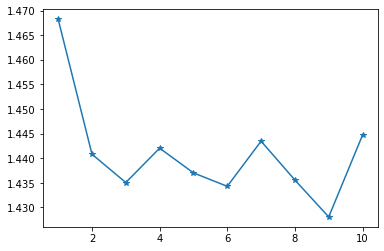

In [1566]:
plt.plot(lb,err, marker= "*")

In [1410]:
var_imp = list(X_val.columns[np.argsort(np.abs(shap_values).mean(0))])
var_imp.reverse()

In [1455]:
print("MAE = ",abs((y_val.values - (model_all.predict(X_val).flatten()))).mean(),
     "RMSE = " ,(((y_val.values - (model_all.predict(X_val).flatten()))**2).mean())**0.5 ,
     "Rsquared = ", r2_score(model_all.predict(X_val).flatten(),y_val))


MAE =  1.5902293845209774 RMSE =  3.198407335435779 Rsquared =  0.7209842868568697


In [1062]:
(y_val.values - (model.predict(X_val))).max()

15.66419656607357

In [892]:
import shap

In [1581]:
explainer = shap.TreeExplainer(model_all)
shap_values = explainer.shap_values(X_train_ex)

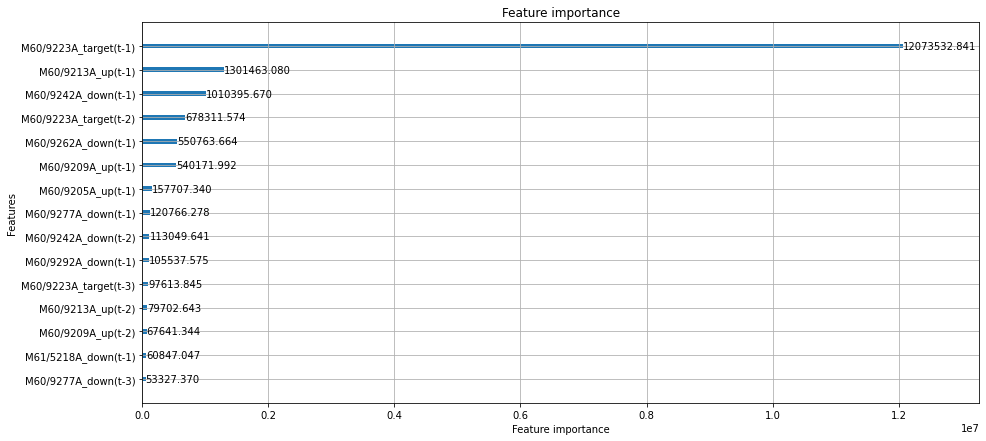

In [1584]:
fig, ax = plt.subplots(figsize = (15,7))
lgb.plot_importance(model_all,ax,max_num_features = 15, importance_type = "gain")

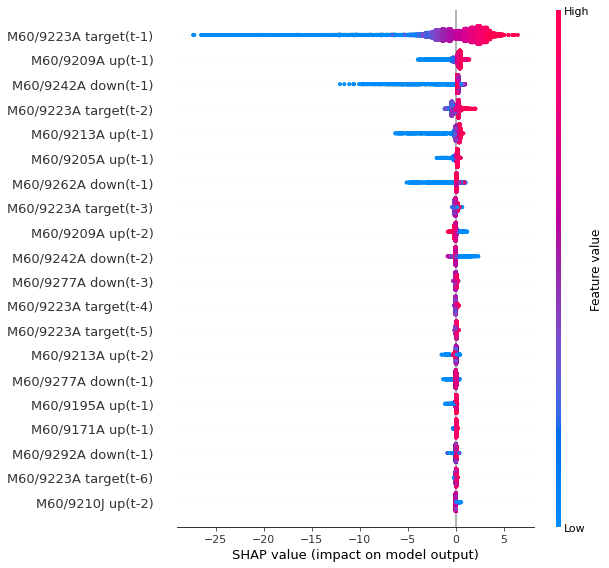

In [1610]:
shap.summary_plot(shap_values, X_train_ex,show= False)
plt.savefig("importance.png",pad_inches=0.5,dpi = 400,bbox_inches="tight")

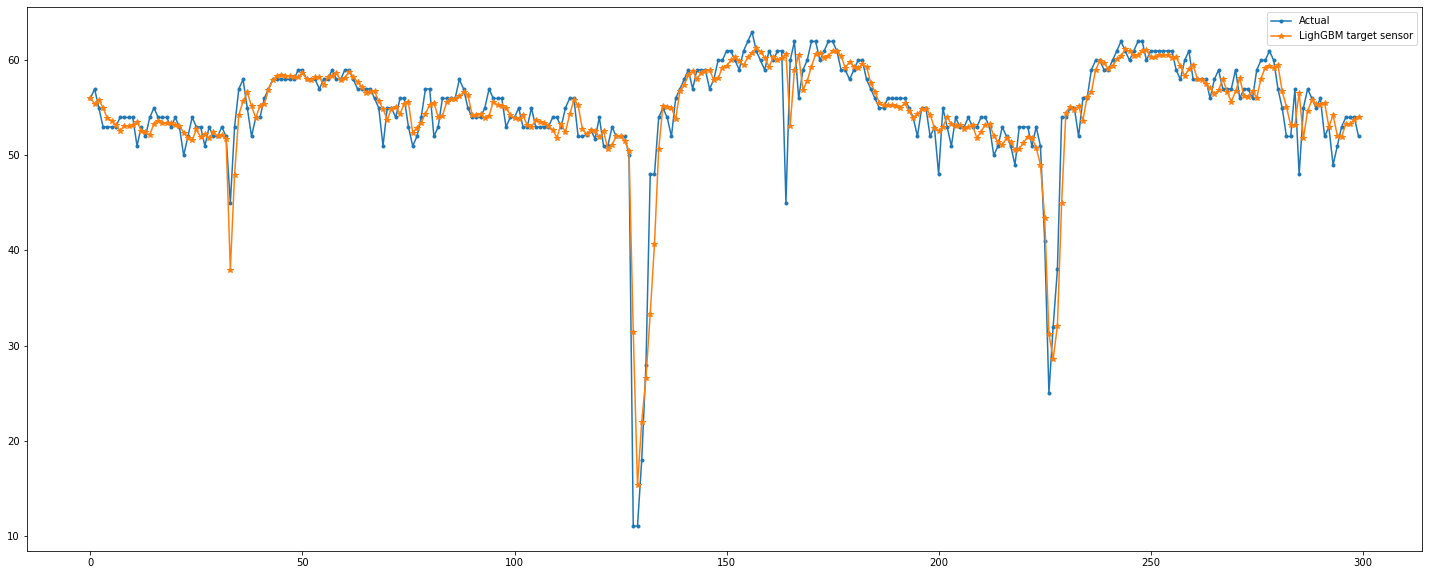

In [1275]:
plt.figure(figsize = (25,10))
plt.plot(y_val.values[700:1000], marker = ".")
#plt.plot(model_uni.predict(X_val_uni)[700:1000], marker = "+")
plt.plot(model_all.predict(X_val)[700:1000], marker = "*")
#plt.plot(model_ex.predict(X_val_ex)[700:1000], marker = "*")
plt.legend(labels = ["Actual","LighGBM target sensor","LighGBM all sensors","LighGBM all sensors + contextual"])

In [1513]:
results = pd.DataFrame({"actual":y_val,"predicted_uni":model_uni.predict(X_val_uni),
                        "predicted_up":model_up.predict(X_val_up),
                        "predicted_down":model_down.predict(X_val_down),
                        "predicted_all":model_all.predict(X_val),"predicted_ex":model_ex.predict(X_val_ex),
                       "predicted_LSTM":lsmodel.predict(X_val_ls).flatten()})


results["AE_uni"] = abs(results["actual"] - results["predicted_uni"])
results["AE_up"] = abs(results["actual"] - results["predicted_up"])
results["AE_down"] = abs(results["actual"] - results["predicted_down"])
results["AE_all"] = abs(results["actual"] - results["predicted_all"])
results["AE_ex"] = abs(results["actual"] - results["predicted_ex"])


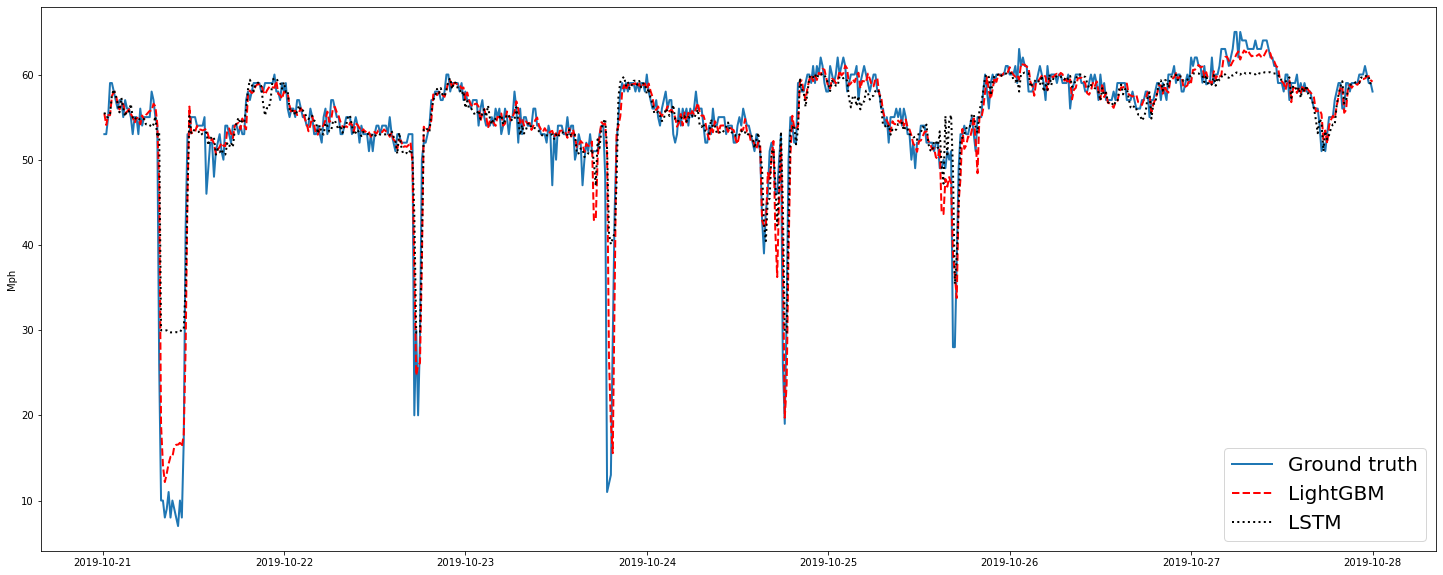

In [1552]:
plt.figure(figsize = (25,10))
plt.plot(results["actual"]["2019-10-21":"2019-10-27"],linewidth = 2)
plt.plot(results["predicted_all"]["2019-10-21":"2019-10-27"], linestyle = "dashed", linewidth = 2, color = "red")
plt.plot(results["predicted_LSTM"]["2019-10-21":"2019-10-27"], linestyle = "dotted", color = "black",linewidth = 2)
plt.legend(labels = ["Ground truth","LightGBM","LSTM"],prop={'size': 20})
plt.ylabel("Mph")
plt.savefig("compare.png", dpi = 400)

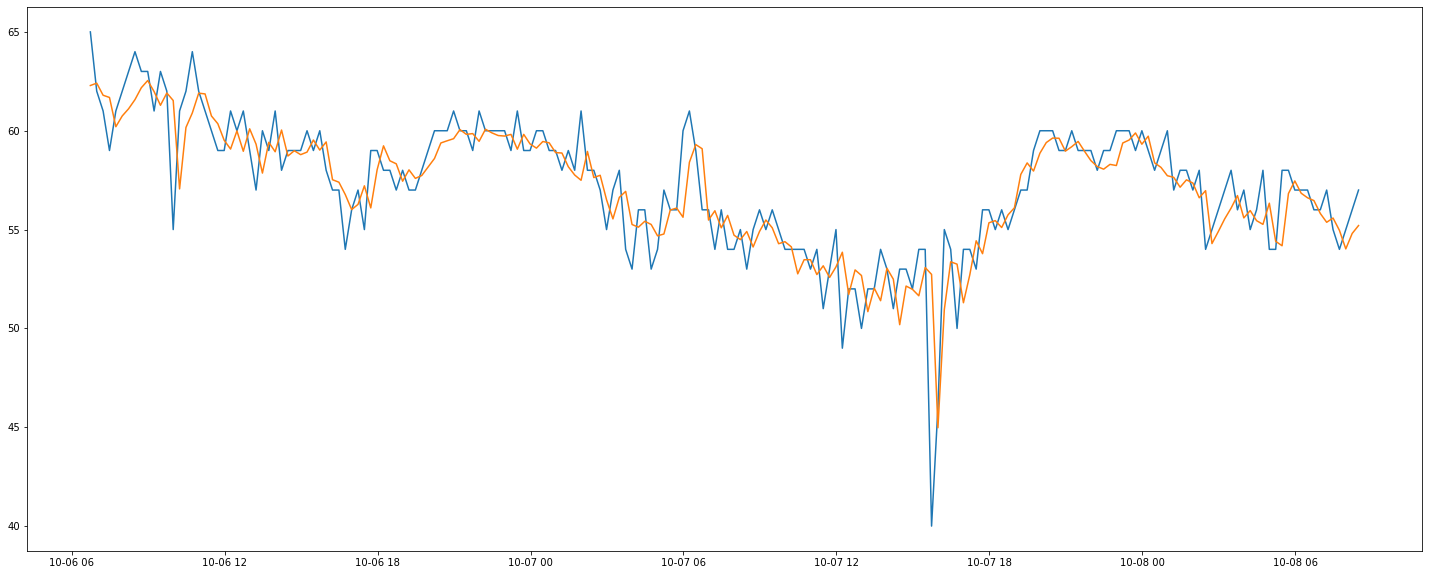

In [1304]:
plt.figure(figsize = (25,10))
plt.plot(results["actual"][500:700])
plt.plot(results["predicted_ex"][500:700])

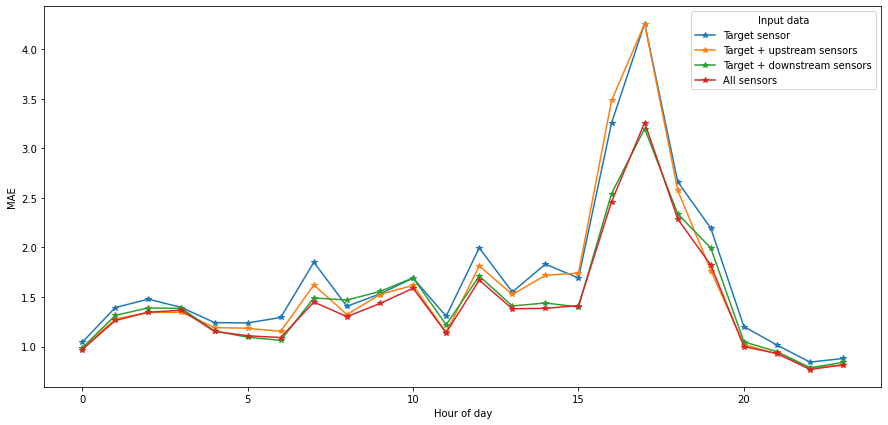

In [1553]:
fig, ax = plt.subplots(figsize = (15,7))
results.groupby(results.index.hour)[["AE_uni","AE_up","AE_down","AE_all"]].mean().plot(ax = ax, marker = "*")
plt.legend(title = "Input data",labels = ["Target sensor","Target + upstream sensors","Target + downstream sensors","All sensors"])
plt.xlabel("Hour of day")
plt.ylabel("MAE")
plt.savefig("timeofday.png",dpi = 400)

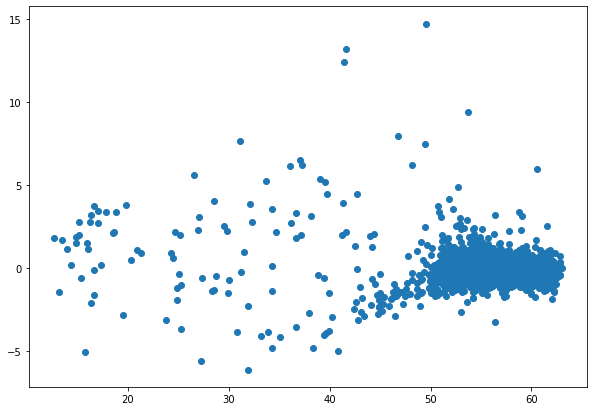

In [1226]:
plt.figure(figsize = (10,7))

errs = (model.predict(X_val)-y_val.values)
errs = errs/errs.std()

plt.scatter(model.predict(X_val),errs)


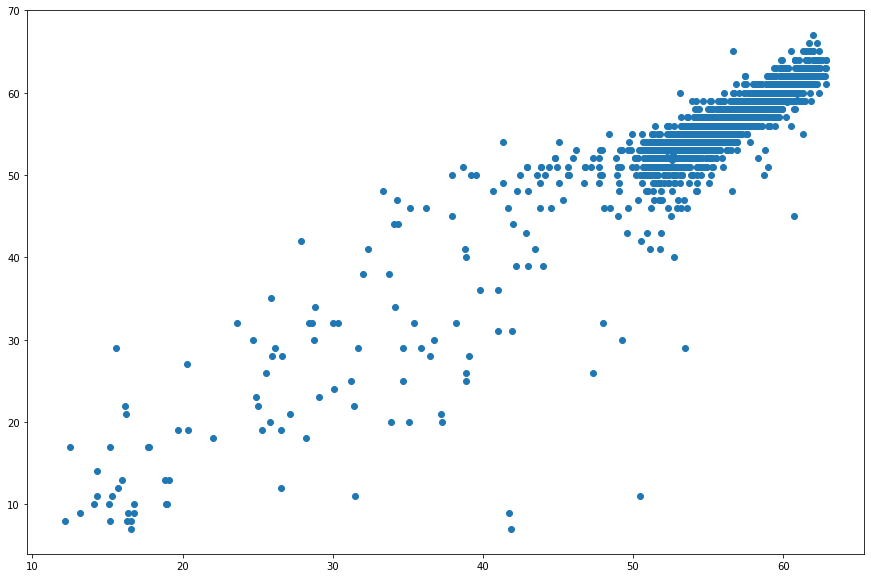

In [1621]:

plt.figure(figsize = (15,10))
plt.scatter(results["predicted_all"],results["actual"])


# LSTM

In [2385]:
#X_train_uni,y_train = series_to_supervised(train_uni,look_back,1)
#X_val_uni,y_val = series_to_supervised(test_uni,look_back,1)


X_train,y_train = series_to_supervised(train,look_back,1)
X_val,y_val = series_to_supervised(test,look_back,1)

# X_train_up,y_train = series_to_supervised(train_up,look_back,1)
# X_val_up,y_val = series_to_supervised(test_up,look_back,1)

# X_train_down,y_train = series_to_supervised(train_down,look_back,1)
# X_val_down,y_val = series_to_supervised(test_down,look_back,1)

#X_train_ex,y_train = series_to_supervised(train_ex,look_back,1)
#X_val_ex,y_val = series_to_supervised(test_ex,look_back,1)

In [2386]:
X_train_ls = array(X_train).reshape(X_train.shape[0],look_back,int(X_train.shape[1]/look_back))
X_val_ls = array(X_val).reshape(X_val.shape[0],look_back,int(X_val.shape[1]/look_back))

In [2387]:


# create and compile the LSTM network
lsmodel = Sequential()
lsmodel.add(LSTM(64, input_shape=(look_back,X_train_ls.shape[2]), return_sequences = False))
lsmodel.add(Dropout(0.05))
lsmodel.add(Dense(1))
lsmodel.compile(loss='mae', optimizer=Adam(0.001))
lsmodel.summary()


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 64)                22016     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 22,081
Trainable params: 22,081
Non-trainable params: 0
_________________________________________________________________


In [2391]:
t0=time()
#Fit LSTM with early stopping based on the validation loss to prevent over fitting 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
lsmodel.fit(X_train_ls,y_train,epochs=50, verbose=1, validation_data = (X_val_ls,y_val), callbacks = es)
print( "training time:", round(time()-t0, 3), "s")

Epoch 1/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8926 - val_loss: 1.5035
Epoch 2/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8989 - val_loss: 1.5436
Epoch 3/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8820 - val_loss: 1.5450
Epoch 4/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8762 - val_loss: 1.5527
Epoch 5/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8735 - val_loss: 1.5554
Epoch 6/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8723 - val_loss: 1.5479
Epoch 7/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8896 - val_loss: 1.5780
Epoch 8/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8721 - val_loss: 1.5283
Epoch 9/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8667 - val_loss: 1.4980
Epoch 10/50
459/459 [==============================] - 1s 3ms/step - loss: 1.8521 - val_loss: 1.5948

In [2392]:
print("MAE = ",abs((y_val.values - (lsmodel.predict(X_val_ls).flatten()))).mean(),
     "RMSE = " ,(((y_val.values - (lsmodel.predict(X_val_ls).flatten()))**2).mean())**0.5 ,
     "Rsquared = ", r2_score(lsmodel.predict(X_val_ls).flatten(),y_val))

MAE =  1.5665564635048814 RMSE =  3.176872196331461 Rsquared =  0.6624104530646704


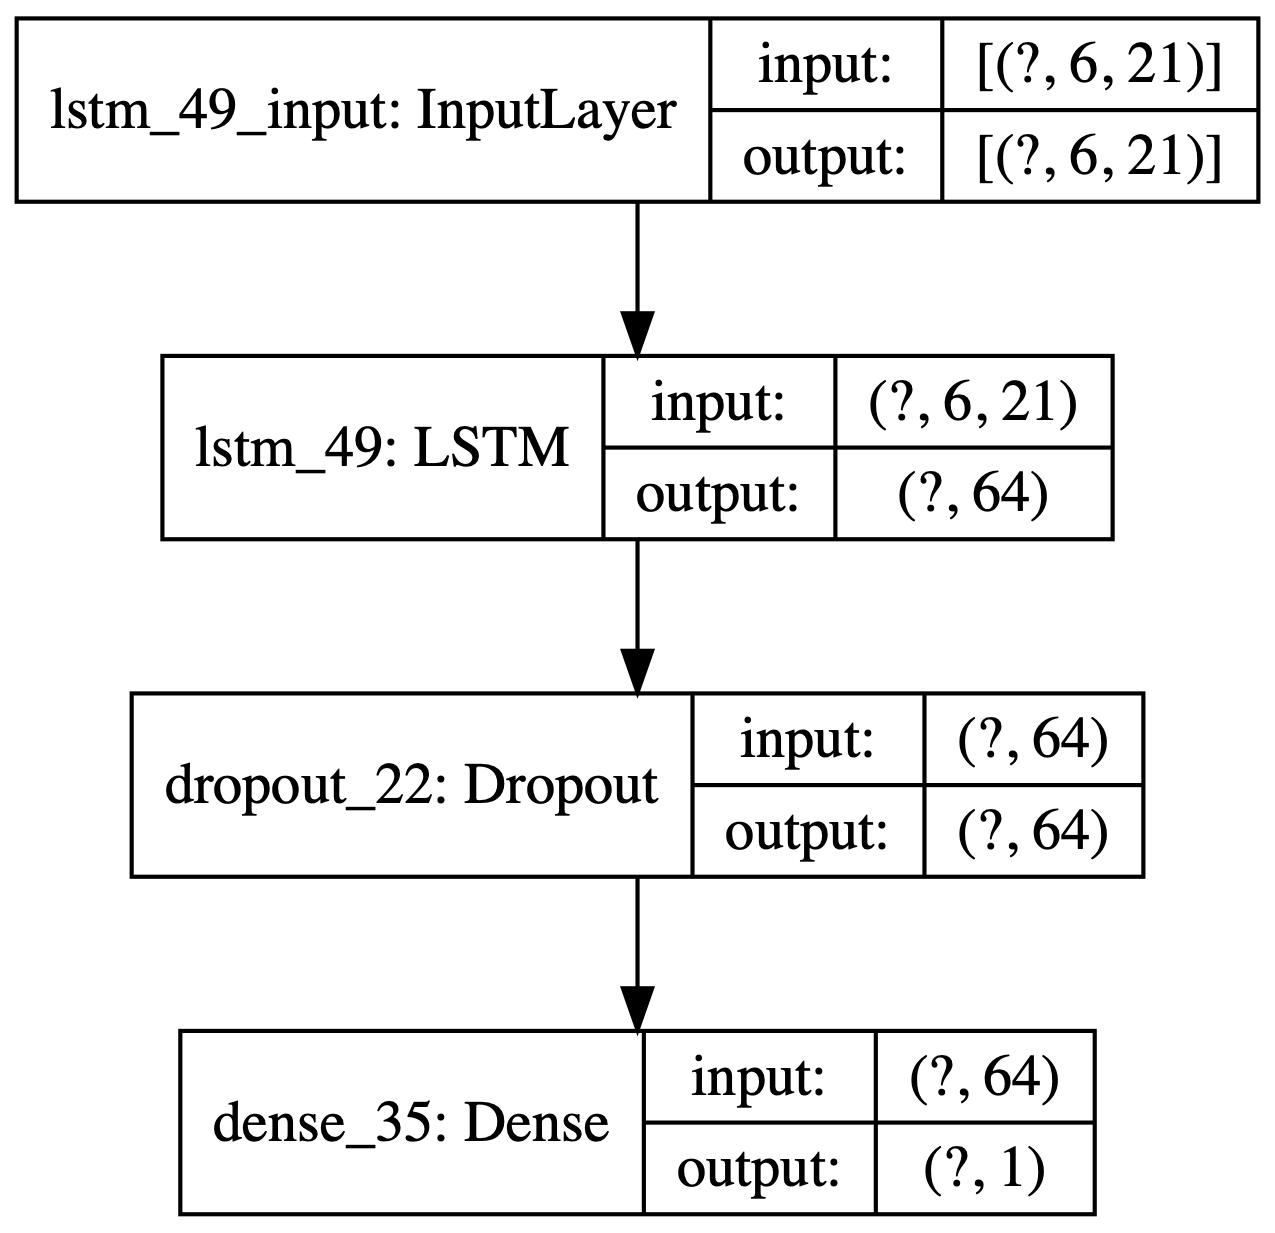

In [2314]:
tf.keras.utils.plot_model(
    lsmodel,
    to_file="model.png",
    show_shapes=True, show_layer_names=True,dpi = 300
)